In [1]:
# Libraries (will need to export to requirements.txt)

from SPARQLWrapper import SPARQLWrapper, JSON
import wikipedia
from tqdm import tqdm
import os
import json
import pandas as pd
import collections
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
 
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\belen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\belen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [57]:
# Pull 100 biographies from wikipedia for each category

In [2]:
DATA_PATH = 'data/'
CATEGORY1 = 'Rabbi'
CATEGORY2 = 'Drag queen'

In [3]:
def get_people(profession):
    sparql = SPARQLWrapper("https://dbpedia.org/sparql")
    
    modified_profession = profession.replace(' ', '_').replace("'", '%27')
    
    query = """
            Select Distinct ?person Where {
                ?person dbo:occupation dbr:%s .
            }
            """ % modified_profession
    
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    ret = sparql.queryAndConvert()
    return(ret['results']['bindings'])

In [4]:
def get_rdf_triples(person):
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    dbpedia_resource = "http://dbpedia.org/resource/" + person
    query = "SELECT ?predicate ?object WHERE { <" + dbpedia_resource + "> ?predicate ?object.}"
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    triples = []
    for result in results["results"]["bindings"]:
        subj = "<"+dbpedia_resource+">"
        pred = result["predicate"]["value"]
        obj = result["object"]["value"]
        triples.append({'subject': subj, 'predicate': pred, 'object': obj})
    return triples

In [5]:
def get_biographies(people, category, limit):
    pages = []
    i = 0
    if not os.path.exists(DATA_PATH):
        print('Data Directory did not exist, creating it now...')
        os.mkdir(DATA_PATH)

    with tqdm(total=limit) as pbar:
        while len(pages) < limit:
            if i >= len(people):
                break
            person = people[i]['person']['value'].split('/')[-1]
            try:
                page = wikipedia.page(person).content
                pages.append(page)
                file_path = os.path.join(DATA_PATH, person + '_' + category.replace(' ', '_'))
                with open(file_path + '.txt', 'w') as f:
                    f.write(page)
                triples = get_rdf_triples(person)
                with open(file_path + '.json', 'w') as f:
                    json.dump(triples, f, indent=4)
                pbar.update(1)
            except Exception as e:
                pass
            i += 1
    return pages

In [6]:
def create_dataset(cat1, cat2, limit=999):
    people1, people2 = (get_people(cat1), get_people(cat2))
    texts1, texts2 = (get_biographies(people1, cat1, limit), get_biographies(people2, cat2, limit))
    df = pd.DataFrame({'text' : texts1+texts2})
    df['category'] = pd.Series([cat1]*len(texts1) + [cat2]*len(texts2))
    return df, texts1, texts2

In [7]:
df, texts1, texts2 = create_dataset(CATEGORY1, CATEGORY2, limit=100)

 60%|██████    | 60/100 [04:55<03:01,  4.53s/it]c:\Users\belen\anaconda3\Lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\belen\anaconda3\Lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')
100%|██████████| 100/100 [08:06<00:00,  4.87s/it]


In [8]:
def clean_text_complete(text):
    dirty_chars = '{}[]()|\/=+`"*,.<>;:#$%&' + "'"
    for char in dirty_chars:
        text = text.replace(char, ' ')
    return text.lower()

In [9]:
def tokenize(text):
    return nltk.word_tokenize(text)

In [13]:
df.head()

,text,category
0,"Capers C. Funnye Jr. (; born April 14, 1952) i...",Rabbi
1,"Samuel Adler (December 3, 1809 – June 9, 1891)...",Rabbi
2,Elie Abadie (Arabic: ايلي عبادي) is Senior Rab...,Rabbi
3,Menahem Shemuel Halevy (Hebrew: מנחם שמואל הלו...,Rabbi
4,Rabbi Menachem Mendel Monsohn (Hebrew: מנחם מע...,Rabbi


In [14]:
df['clean_text'] = df['text'].apply(clean_text_complete)

In [15]:
df['tokenized'] = df['clean_text'].apply(tokenize)

In [16]:
df

,text,category,clean_text,tokenized
0,"Capers C. Funnye Jr. (; born April 14, 1952) i...",Rabbi,capers c funnye jr born april 14 1952 i...,"[capers, c, funnye, jr, born, april, 14, 1952,..."
1,"Samuel Adler (December 3, 1809 – June 9, 1891)...",Rabbi,samuel adler december 3 1809 – june 9 1891 ...,"[samuel, adler, december, 3, 1809, –, june, 9,..."
2,Elie Abadie (Arabic: ايلي عبادي) is Senior Rab...,Rabbi,elie abadie arabic ايلي عبادي is senior rab...,"[elie, abadie, arabic, ايلي, عبادي, is, senior..."
3,Menahem Shemuel Halevy (Hebrew: מנחם שמואל הלו...,Rabbi,menahem shemuel halevy hebrew מנחם שמואל הלו...,"[menahem, shemuel, halevy, hebrew, מנחם, שמואל..."
4,Rabbi Menachem Mendel Monsohn (Hebrew: מנחם מע...,Rabbi,rabbi menachem mendel monsohn hebrew מנחם מע...,"[rabbi, menachem, mendel, monsohn, hebrew, מנח..."
...,...,...,...,...
195,"Jade Jolie is the stage name of Jules Green, a...",Drag queen,jade jolie is the stage name of jules green a...,"[jade, jolie, is, the, stage, name, of, jules,..."
196,"Jared Johnson (born December 9, 1988), best kn...",Drag queen,jared johnson born december 9 1988 best kn...,"[jared, johnson, born, december, 9, 1988, best..."
197,"Justin Omar Mooijer (born 9 April 1992), known...",Drag queen,justin omar mooijer born 9 april 1992 known...,"[justin, omar, mooijer, born, 9, april, 1992, ..."
198,"Martell Robinson (born October 16, 1976), know...",Drag queen,martell robinson born october 16 1976 know...,"[martell, robinson, born, october, 16, 1976, k..."


In [17]:
# Create 50 most common word per category and word cloud

In [18]:
def get_all_tokens(df, category):
    tokens = []
    for series in df[df["category"] == category]['tokenized']:
        for t in series:
            tokens.append(t)
    return tokens

In [19]:
tokens1 = get_all_tokens(df, CATEGORY1)
tokens2 = get_all_tokens(df, CATEGORY2)

In [31]:
def remove_stopwords(tokens, stop_words):
    '''
    This function removes stopwords from a list of tokens.
    Parameters:
    - tokens = list of tokens.
    - stop_words = list of stopwords
    Output: 
    - tokens = list of tokens without stopwords 
    '''
    for token in tokens:
        if token in stop_words:
            tokens.remove(token)
    return tokens

In [32]:
stopwords_en = stopwords.words('english') #I added into a list variable to fix the function.

In [33]:
tokens1_nostop = remove_stopwords(tokens1, stopwords_en)
tokens2_nostop = remove_stopwords(tokens2, stopwords_en)

In [34]:
def make_wordcloud(tokens, n_words):
    data = collections.Counter(tokens).most_common(n_words)
    word_frequencies = {word: freq for word, freq in data}

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

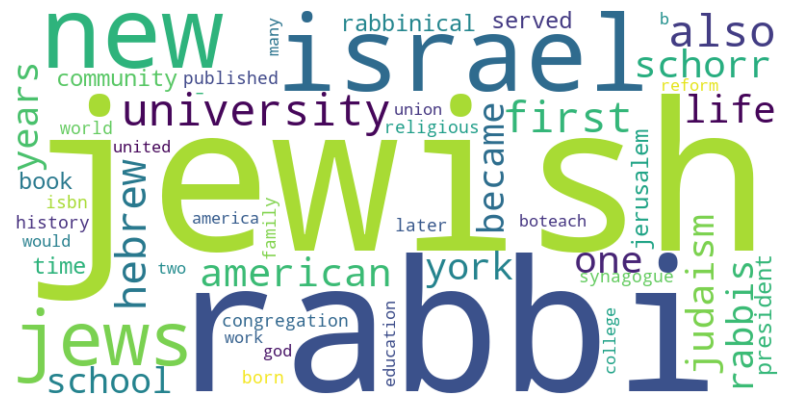

In [35]:
make_wordcloud(tokens1_nostop, 50)

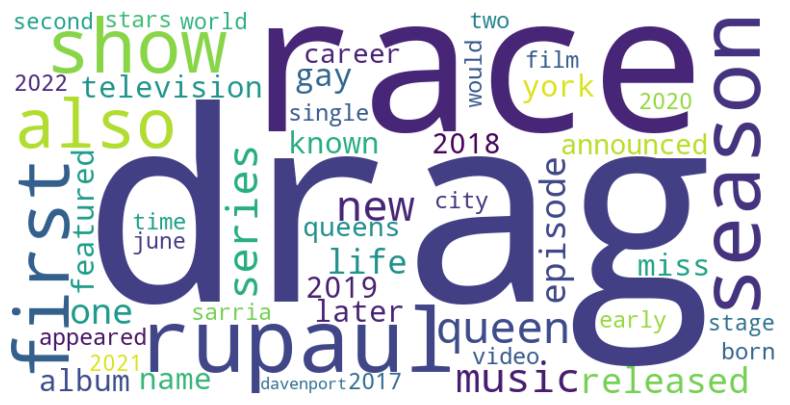

In [36]:
make_wordcloud(tokens2_nostop, 50)

In [37]:
# Create histogram and boxplot for sentence length per category with min/max/avg

In [41]:
def get_sentences(series):
    sentences = []
    for item in series:
        for para in item.split('\n'):
            for sent in nltk.sent_tokenize(para):
                sentences.append(sent)
    return sentences

In [43]:
sentences1 = get_sentences(df[df['category'] == CATEGORY1]['text'])
sentences2 = get_sentences(df[df['category'] == CATEGORY2]['text'])

In [44]:
def get_length_dict(sentences):
    lengths = {}
    longest_sentence = ""
    shortest_sentence = "Pretty sure it's smaller than this"
    for sentence in sentences:
        len_sentence = len(sentence.split(' '))
        if len_sentence > len(longest_sentence.split(' ')):
            longest_sentence = sentence
        if len_sentence < len(shortest_sentence.split(' ')):
            shortest_sentence = sentence
        if lengths.get(len_sentence):
            lengths[len_sentence] += 1
        else:
            lengths[len_sentence] = 1
    expanded = []
    for key, count in lengths.items():
        expanded.extend([key] * count)
    return lengths, expanded, longest_sentence, shortest_sentence

In [45]:
length_sentence1, expanded1, longest_sentence1, shortest_sentence1 = get_length_dict(sentences1)
length_sentence2, expanded2, longest_sentence2, shortest_sentence2 = get_length_dict(sentences2)

In [46]:
print('Min Sentence Length Category 1:', min(length_sentence1))
print('Max Sentence Length Category 1:', max(length_sentence1))
print('Avg Sentence Length Category 1:', sum(length_sentence1) / len(length_sentence1))
print('Min Sentence Length Category 2:', min(length_sentence2))
print('Max Sentence Length Category 2:', max(length_sentence2))
print('Avg Sentence Length Category 2:', sum(length_sentence2) / len(length_sentence2))

Min Sentence Length Category 1: 1
Max Sentence Length Category 1: 80
Avg Sentence Length Category 1: 25.148936170212767
Min Sentence Length Category 2: 1
Max Sentence Length Category 2: 64
Avg Sentence Length Category 2: 24.26086956521739


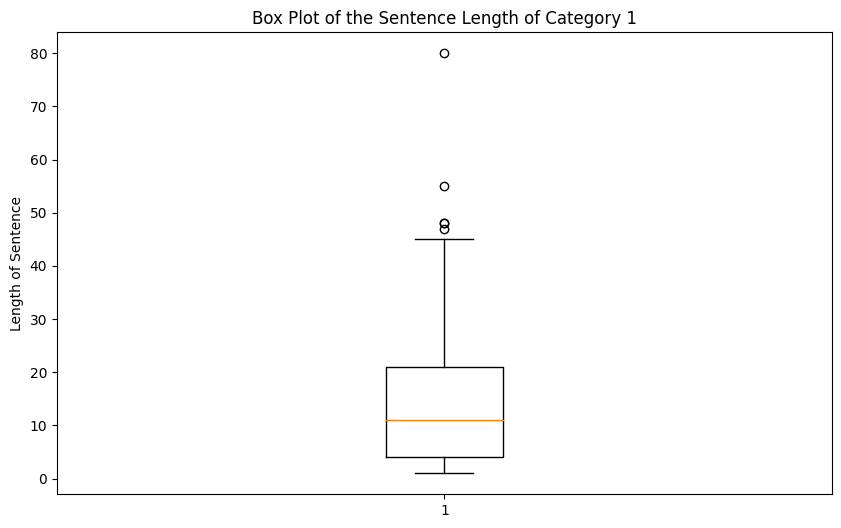

In [47]:
plt.figure(figsize=(10, 6))
plt.boxplot(expanded1)
plt.title("Box Plot of the Sentence Length of Category 1")
plt.ylabel("Length of Sentence")
plt.show()

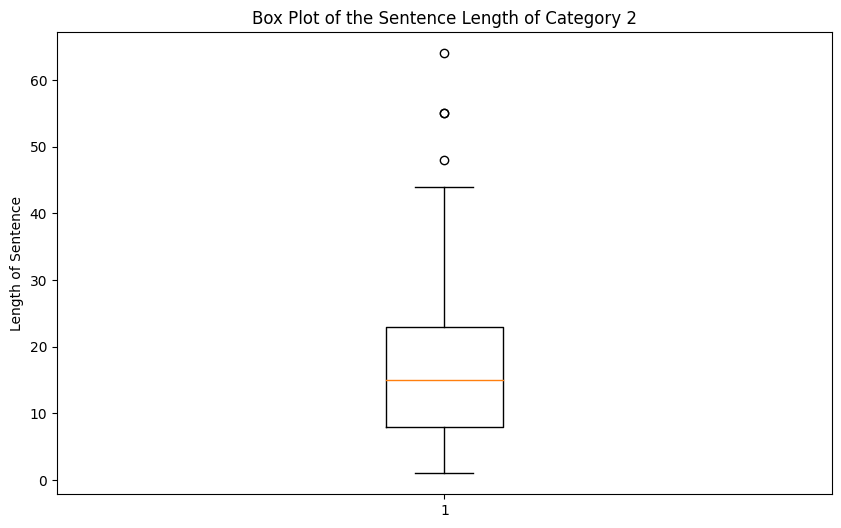

In [48]:
plt.figure(figsize=(10, 6))
plt.boxplot(expanded2)
plt.title("Box Plot of the Sentence Length of Category 2")
plt.ylabel("Length of Sentence")
plt.show()

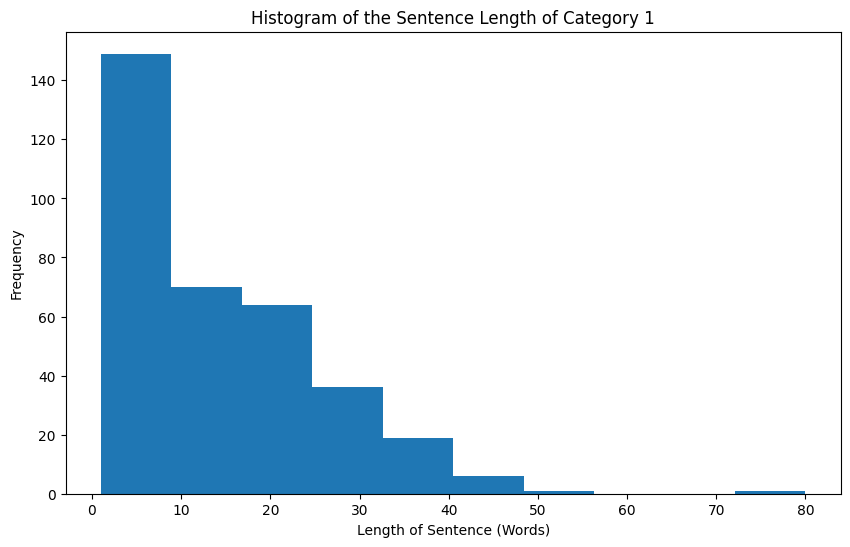

In [49]:
plt.figure(figsize=(10, 6))
plt.hist(expanded1)
plt.title("Histogram of the Sentence Length of Category 1")
plt.ylabel("Frequency")
plt.xlabel("Length of Sentence (Words)")
plt.show()

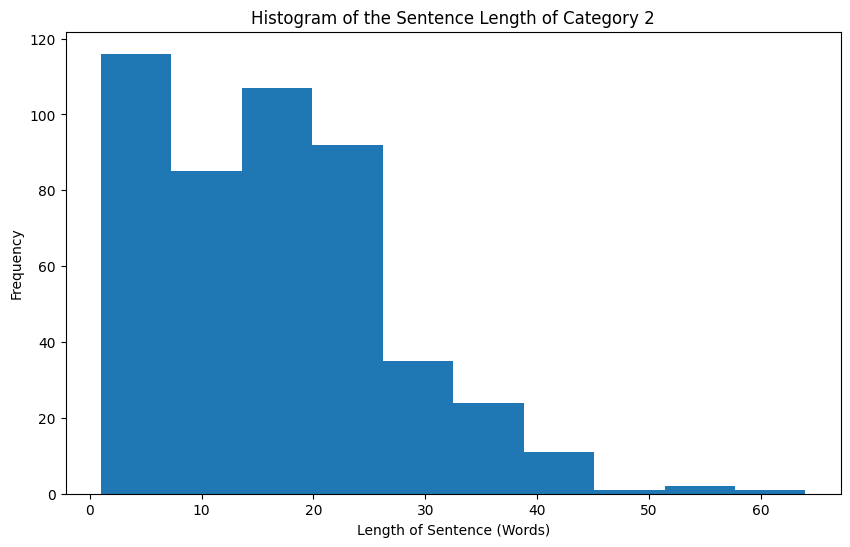

In [50]:
plt.figure(figsize=(10, 6))
plt.hist(expanded2)
plt.title("Histogram of the Sentence Length of Category 2")
plt.ylabel("Frequency")
plt.xlabel("Length of Sentence (Words)")
plt.show()

In [ ]:
# ?? Total number of bi-gram occurences per category. min/max/avg

In [51]:
def collect_bigrams(tokens):
    bigrams = nltk.bigrams(tokens)
    occurences = {}
    for bigram in bigrams:
        if occurences.get(bigram):
            occurences[bigram] += 1
        else:
            occurences[bigram] = 1
    return occurences

In [52]:
bigrams1 = collect_bigrams(tokens1)
bigrams2 = collect_bigrams(tokens2)

In [53]:
bigrams_longest1 = collect_bigrams(longest_sentence1.split(' '))
bigrams_longest2 = collect_bigrams(longest_sentence2.split(' '))

In [54]:
bigrams_shortest1 = collect_bigrams(shortest_sentence1.split(' '))
bigrams_shortest2 = collect_bigrams(shortest_sentence2.split(' '))

In [55]:
print("Number of unique bigram occurences in Category 1:", len(bigrams1))
print("\tUnique bigrams in shortest:\t\t", len(bigrams_shortest1))
print("\tUnique bigrams in longest:\t\t", len(bigrams_longest1))
print("Number of unique bigram occurences in Category 2:", len(bigrams2))
print("\tUnique bigrams in shortest:\t\t", len(bigrams_shortest1))
print("\tUnique bigrams in longest:\t\t", len(bigrams_longest1))

Number of unique bigram occurences in Category 1: 3039
	Unique bigrams in shortest:		 0
	Unique bigrams in longest:		 77
Number of unique bigram occurences in Category 2: 4705
	Unique bigrams in shortest:		 0
	Unique bigrams in longest:		 77


In [ ]:
# Query rdf properties for 50 most frequent properties (I think this means predicates) and create word cloud

In [ ]:
# Create histograms and boxplot for number of facts per category. min/max/avg

In [ ]:
# Train KMeans clustering (n_clusters=2). Cluster based on text (?) and, separately, on facts

In [ ]:
# Compute supervised and unsupervised metrics and visualizations to compare results

In [ ]:
# Function that process a document and return the set of named entities(NEs) (Spacy)

In [ ]:
# Same as above but with Stanza

In [ ]:
# Get statistics for each output (avg/min/max number of NEs)

In [ ]:
# Get statistics for each output (avg/min/max number of words (unclear use of word 'word'))

In [ ]:
# Visualize the above 2 statistics (per category, per package)

In [ ]:
# Write a function that takes a single document and performs the following 5 tasks

In [ ]:
    # Returns # of spans that both packages agree on

In [ ]:
    # Returns # of partial agreements on spans

In [ ]:
    # Returns for each package # of spans that one package predicted as a NE and the other did not

In [ ]:
    # Returns for all spans with full and partial agreement, agreement about NE types (aka Person, Location, Organisation, etc.)

In [ ]:
    # Visualize the above statistics

In [ ]:
# For each set of NEs predicted by each package, how many of them can be found in the knowledge graph (KG)

In [ ]:
# For each package, the ratio of predicted NEs that can be found in the KG of a person

In [ ]:
# Bonus points